<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Neuroscience of Learning, Memory, Cognition <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    Spring 2024<br>
<font color=3C99D size=5>
    Practical Assignment 3 <br>
<font color=696880 size=4>

- Name = Ardalan Gerami
- Student ID = 99102112

---
# Finetuning CNN using regression loss  

- CNN are proven to be a better model of visual cortex, but the goal of visual cortex is not limited to image classification.

- Typically, to model visual cortex responses using CNNs, we -

  1. Extract features of intermediate layers
  2. Reduce dimensionality of the data using techniques like PCA
  3. Perform regression to predict neural data.

- This approach fails to predict all the variance in the data.

**A better approach is to train CNNs directly on the neural response.**

- CNNs are built to somehow mimic the functionality of the visual system. They are able to achieve a high performance on many tasks, that were previously believed to be impossible for machines to solve. We are going to explore them in this assignment.

    1. Explain about the visual system, focusing on the data flow (You should explain the pathways in the visual system).
        - The visual system processes visual information through a series of pathways, starting from the retina, where light is converted into neural signals. These signals travel via the optic nerve to the lateral geniculate nucleus (LGN) of the thalamus, and then to the primary visual cortex (V1) in the occipital lobe. From V1, the data flows along two main pathways: the dorsal stream (to the parietal lobe) for spatial awareness and movement, and the ventral stream (to the temporal lobe) for object recognition and form.
    2. What does each part of the visual system reveal about the stimuli (You should explain about the features that each part detects, like lines, angles, ...)?
        - In the visual system, the retina detects light and dark contrasts. The lateral geniculate nucleus (LGN) processes basic features like edges and color. The primary visual cortex (V1) detects lines, angles, and simple shapes. Higher visual areas in the dorsal stream analyze motion and spatial relationships, while the ventral stream focuses on complex shapes, object identities, and color details.
    3. Compare the CNNs with the visual system. How are they alike and in which parts, do they converge?
        - CNNs and the visual system are alike in their hierarchical processing of visual information, starting with simple features and building up to complex representations. Early CNN layers detect basic edges and textures, akin to the retina and V1 in the visual system. Mid-level CNN layers recognize shapes and patterns, similar to higher visual areas. Both systems converge in higher layers, where abstract and complex features like objects and scenes are recognized.
    4. Explain about different learning strategies that we can deploy on the neural networks. What learning strategies have neurological evidence? 
        - Different learning strategies for neural networks include supervised learning (using labeled data), unsupervised learning (finding patterns in unlabeled data), semi-supervised learning (combining both labeled and unlabeled data), and reinforcement learning (learning via rewards and punishments). Neurological evidence supports reinforcement learning, which mimics the brain's reward-based learning through dopamine signals, and unsupervised learning, reflecting the brain's ability to detect patterns and structures without explicit labels.



---
# Setup

We are now exploring some simple tasks using pytorch.


- We are going to use the following package : torch_intermediate_layer_getter.
Search What it does and why we do that ?############## TO DO ###############

    - It enables you to specify which layers' outputs we want to extract when we pass an input through the model. Also By extracting the outputs of intermediate layers, we can inspect the feature maps, which can be useful for understanding what the model is learning at different stages. It can be used to extract features from a pre-trained model's intermediate layers, which can then be used for tasks like transfer learning or as inputs to another model.
    - In transfer learning, We often use a pre-trained model and extract features from its intermediate layers to train a new model on a different task. Intermediate features from a pre-trained model are often more useful than the final output for many downstream tasks. Also by examining the outputs of intermediate layers, we can gain insights into how the model processes the input data, which can be valuable for debugging and visualizing the learning process.



In [114]:
# @title Install dependencies
!pip install Pillow --quiet
!pip install torch_intermediate_layer_getter --quiet


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [115]:
#  Imports
import copy

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter

from torchvision import transforms
import torchvision.models as models


from scipy.spatial.distance import pdist
from scipy.stats import pearsonr

# Add more if you need

next cell download and extract data, for better understanding task search about dataset properties and write down results below:############## TO DO ###############


- Data Keys: The keys in the loaded dat dictionary provide an overview of what data is available. Typically, this might include training stimuli, test stimuli, and other relevant arrays.

- Stimuli Shape: The shape of the stimuli array indicates the number of training images and their dimensions.

- Stimuli Test Shape: The shape of the stimuli_test array provides information about the number of test images and their dimensions.

- Labels Shape: The shape of the labels array indicates the number of labels corresponding to the training images.

- Validation Labels Shape: The shape of the val_labels array indicates the number of labels corresponding to the test images.

In [116]:
# @title Downloading Kay dataset
import requests

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]

urls =['https://osf.io/r638s/download',
       'https://osf.io/yqb3e/download',
      'https://osf.io/ymnjv/download']

for i, url in enumerate(urls):
  r = requests.get(url, allow_redirects=True)
  with open(fnames[i], 'wb') as fh:
    fh.write(r.content)


with np.load(fnames[2]) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

It is always a good idea to look at the data we are dealing with. Visualize some samples and plot them below.

C:\Users\AsusIran\AppData\Local\Temp\ipykernel_2060\2329771542.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


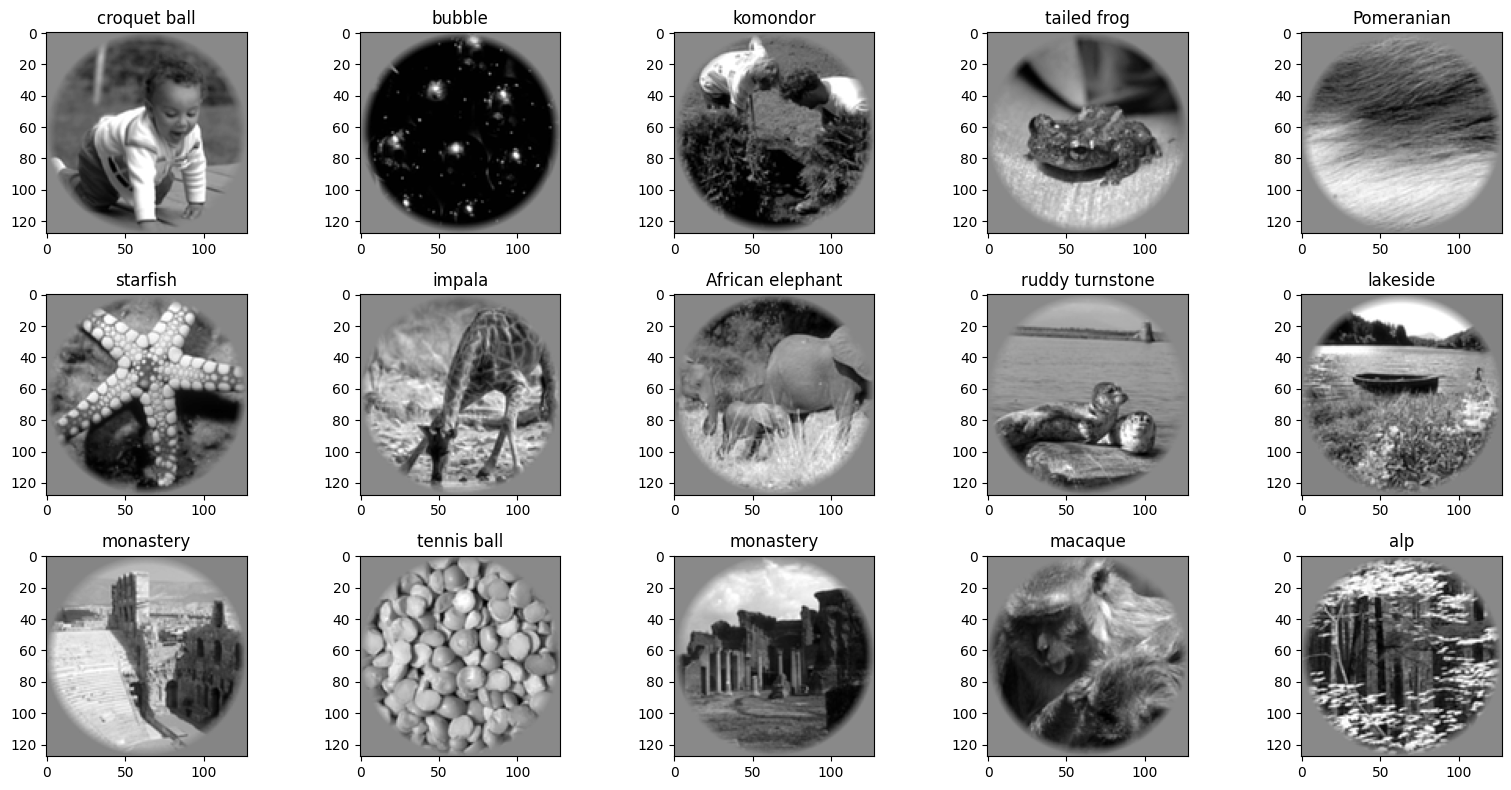

In [117]:
# @title Visualizing example images
############## TO DO ###############
fig, axes = plt.subplots(3, 5, figsize=(16, 8))
for ax, image, label in zip(axes.flat, dat["stimuli"], labels[-1, :]):
  ax.imshow(image, cmap="gray")
  ax.set_title(label)
fig.tight_layout()
fig.show()

---
# Dataset Structure

While using the neural networks, we have to be careful about the dimensions and the stimuli we are feeding the network with.

`dat` has the following fields:  
- `stimuli`: stim $x_i \, \, x_j$ array of grayscale stimulus images
- `stimuli_test`: stim $x_i \, \, x_j$ array of grayscale stimulus images in the test set  
- `responses`: stim $x$ voxel array of $z$-scored BOLD response amplitude
- `responses_test`:  stim $x$ voxel array of $z$-scored BOLD response amplitude in the test set  
- `roi`: array of voxel labels
- `roi_names`: array of names corresponding to voxel labels

Based of Letcures, describe roi and roi_names and match with the dataset?
############## TO DO ###############
- ROI (Region of Interest) and ROI Names are critical concepts in neuroscience, particularly in the context of functional Magnetic Resonance Imaging (fMRI) studies. They help in understanding and analyzing brain activity related to specific tasks or stimuli.
-  In the dataset, the "roi" field contains an array of voxel labels. Voxels are the 3D equivalent of pixels in imaging data, representing small cubes of brain tissue. Each voxel label in the "roi" array indicates which brain region (or ROI) the voxel belongs to.
- The "roi_names" field contains an array of names corresponding to the voxel labels in the roi array. Each name represents a specific brain region that has been labeled as an ROI.
- Stimuli: The stimuli field contains arrays of grayscale stimulus images used for training.

- Stimuli Test: The stimuli_test field contains arrays of grayscale stimulus images used for testing.

- Responses: The responses field contains an array of $z$-scored BOLD (Blood-Oxygen-Level Dependent) response amplitudes for the training stimuli. These responses are recorded from various voxels in the brain while subjects view the training images.

- Responses Test: The responses_test field contains an array of $z$-scored BOLD response amplitudes for the test stimuli.

- ROI: The roi field contains labels for each voxel, indicating which ROI (brain region) each voxel belongs to.

- ROI Names: The roi_names field contains the names of the ROIs, providing a reference for the labels in the roi field.

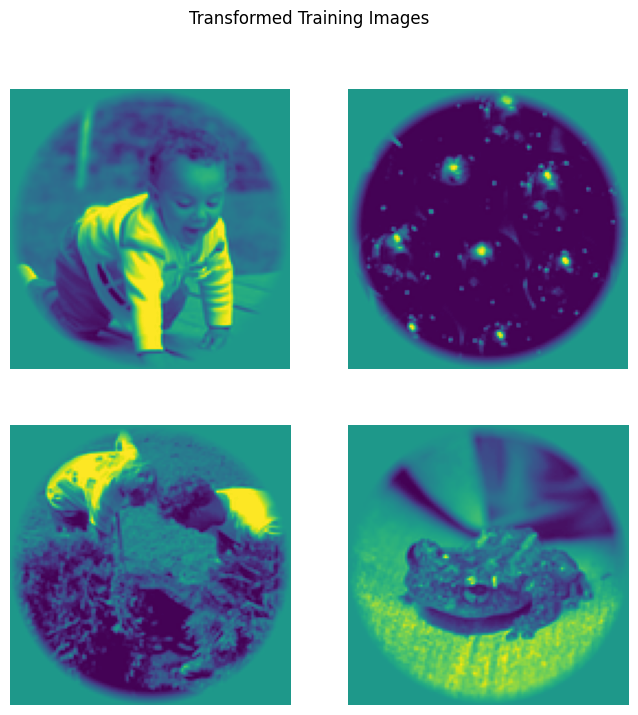

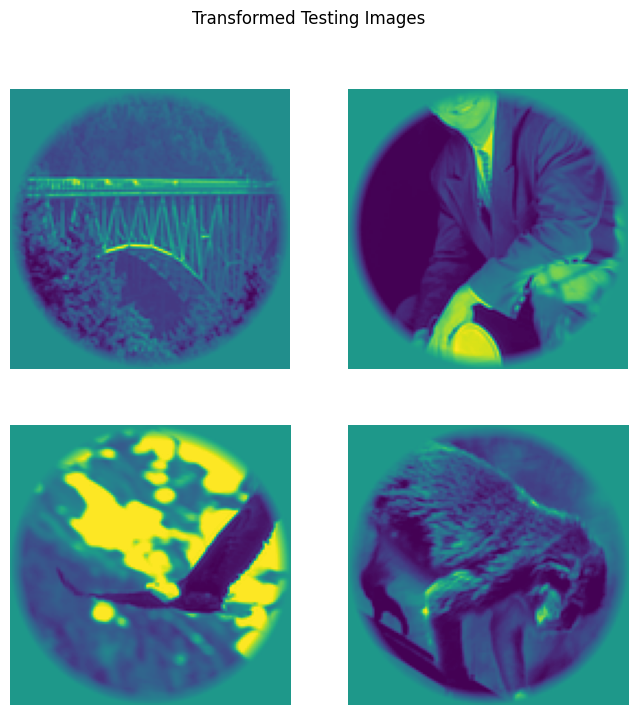

In [118]:
# Converting stimulus to RGB and changing the scale to 0-255 (Specific to Kay dataset images)
stimuli_tr = dat["stimuli"]
stimuli_ts = dat["stimuli_test"]
stimuli_tr_xformed = np.zeros((1750, 3, 128, 128))
stimuli_ts_xformed = np.zeros((120, 3, 128, 128))
############## TO DO ###############
for i in range(1750):
    img = ((stimuli_tr[i, :, :] - np.min(stimuli_tr[i, :, :])) * 255 / (np.max(stimuli_tr[i, :, :]) - np.min(stimuli_tr[i, :, :]))).astype(int)
    stimuli_tr_xformed[i] = np.stack([img, img, img], axis=0)
for i in range(120):
    img = ((stimuli_ts[i, :, :] - np.min(stimuli_ts[i, :, :])) * 255 / (np.max(stimuli_ts[i, :, :]) - np.min(stimuli_ts[i, :, :]))).astype(int)
    stimuli_ts_xformed[i] = np.stack([img, img, img], axis=0)
def plot_images(images, title):
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.imshow(images[i][0])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()
plot_images(stimuli_tr_xformed, "Transformed Training Images")
plot_images(stimuli_ts_xformed, "Transformed Testing Images")

---
# Fine Tuning AlexNet on voxel activations





It is previously demonstrated that simple features are extracted in the early layers of the neural network, so it is a good idea to use pre-trained nets which are trained on enormous data sets and just modify the final layers.

1- Search about fine tuning. Why do we fine tune in the first place?
 - Fine-tuning is a process in deep learning where a pre-trained model, typically trained on a large dataset, is adapted to perform well on a different but related task. This involves taking an existing model that has already learned useful features and further training it on a new dataset to improve its performance on a specific task.
 - Fine-tuning with pre-trained weights can help prevent overfitting, especially when the new dataset is small. The pre-trained model provides a strong inductive bias, guiding the learning process in a useful direction.
 - Training a model from scratch requires significant computational resources and time. Fine-tuning a pre-trained model is much more efficient since the initial training phase has already been completed.
 - Lower layers of the pre-trained model capture generic features like edges and textures, which are useful for many visual tasks. Higher layers capture more abstract features relevant to the original task, which can often be adapted to the new task with some additional training.
 
2- Search about different situations where fine tuning is done.
 - Transfer Learning for Computer Vision : Models like Faster R-CNN or YOLO, pre-trained on large datasets, are fine-tuned to detect objects in a custom dataset.
 - Natural Language Processing (NLP) : Pre-trained language models like BERT, GPT, or RoBERTa are fine-tuned to classify texts into categories such as sentiment analysis, spam detection, or topic classification.
 - Speech Recognition and Processing : Pre-trained models such as Wav2Vec or DeepSpeech are fine-tuned on domain-specific datasets to improve transcription accuracy for particular accents, languages, or specialized vocabulary.
 - Reinforcement Learning : Fine-tuning models for specific robotic tasks, such as grasping objects or navigating environments, building on general pre-trained reinforcement learning models.
 
3- Name the different layers that are present in AlexNet. Briefly explain each layer's role. On what layers do we perform fine tuning?
 * Input Layer : Accepts the input image. The input to AlexNet is a fixed-size 227x227 RGB image.
 * Convolutional Layers:

   * First Convolutional Layer: Applies 96 kernels of size 11x11 with a stride of 4 and padding of 0, resulting in an output feature map of size 55x55x96. It captures low-level features like edges, colors, and textures.

   * Second Convolutional Layer: Applies 256 kernels of size 5x5 with a stride of 1 and padding of 2, resulting in an output feature map of size 27x27x256. It captures more complex patterns and structures.

   * Third Convolutional Layer: Applies 384 kernels of size 3x3 with a stride of 1 and padding of 1, resulting in an output feature map of size 13x13x384. It captures even more complex patterns.

   * Fourth Convolutional Layer: Applies 384 kernels of size 3x3 with a stride of 1 and padding of 1, resulting in an output feature map of size 13x13x384. It captures higher-level abstractions.

   * Fifth Convolutional Layer: Applies 256 kernels of size 3x3 with a stride of 1 and padding of 1, resulting in an output feature map of size 13x13x256. It captures the highest-level features in the hierarchy.

 * Pooling Layers: Reduce the spatial dimensions (width and height) of the feature maps while retaining the most important information. AlexNet uses max pooling layers after the first, second, and fifth convolutional layers with a kernel size of 3x3 and a stride of 2.
 * Normalization Layers: Perform Local Response Normalization (LRN) after the first and second convolutional layers. This step helps in enhancing the generalization by normalizing the output and creating competition between neuron outputs mapped by adjacent kernels.
 * Fully Connected (FC) Layers:
   * First Fully Connected Layer: Takes the flattened output of the last pooling layer (6x6x256 = 9216 neurons) and applies 4096 neurons. This layer captures high-level abstractions and patterns in the data.
   * Second Fully Connected Layer: Applies another 4096 neurons, further abstracting and learning complex representations.
   * Third Fully Connected Layer (Output Layer): Applies a final layer with 1000 neurons, corresponding to the 1000 classes in the ImageNet dataset. This layer uses a softmax activation function to produce a probability distribution over the classes.


 - Fine-tuning is typically performed on the higher layers of a pre-trained network:
 
    Fully Connected Layers - Higher Convolutional Layers

In [119]:
# @title Setting up training and test data for LOC region (roc = 7)
############## TO DO ###############
roi = 7
roi_indices = np.where(dat['roi'] == roi)[0]
response_tr = dat['responses'][:, roi_indices]
response_ts = dat['responses_test'][:, roi_indices]

When and Why we use transform function for dataset.
############## TO DO ###############
- When?
    - Preprocessing:
        - Normalization: When the input data needs to be normalized to a specific range (e.g., [0, 1] or mean-zero unit-variance), transforms are applied.
        - Resizing: When the input images need to be resized to a specific dimension required by the model (e.g., 224x224 for ResNet or 227x227 for AlexNet).
        - Centering and Cropping: When images need to be cropped to a smaller size after centering, often used to focus on the central part of the image.
    - Data Augmentation:
        - Training: During training, data augmentation techniques such as random rotations, flips, translations, and color changes are applied to artificially expand the training dataset and improve model generalization.
        - Testing/Validation: Typically, only basic preprocessing (e.g., normalization, resizing) is applied without augmentation to ensure consistency in evaluation.
    - Preparing for Model Input:
        - Tensor Conversion: When the input images need to be converted to tensors, which are the required input format for most deep learning frameworks like PyTorch.
        - Batch Preparation: To ensure that the input data is in the right shape and format to be fed into the model during training and evaluation.
- Why?
    - Normalization: Normalizing images ensures that the pixel values are in a consistent range, which helps with faster and more stable convergence during training.
    - Resizing and Cropping: Most neural network architectures require inputs of a fixed size. Resizing ensures that all input images conform to this requirement.
    - Data Augmentation: Augmentation techniques introduce variability in the training data, making the model more robust and improving its ability to generalize to unseen data.
    - Tensor Conversion: Deep learning frameworks like PyTorch work with tensors, so images need to be converted from PIL or NumPy arrays to tensors.
    - Improving Model Performance: Properly preprocessed and augmented data helps in achieving better model performance by ensuring that the model learns relevant features and is robust to variations in the data.


In [188]:
# @title Custom dataloader for loading images in numpy array
# use MyDatast or use your own dataloader.
class MyDataset(Dataset):
  def __init__(self, data, targets, transform=None):
    self.data = data
    self.targets = torch.LongTensor(targets)
    self.transform = transform

  def __getitem__(self, index):
    x = self.data[index]
    y = self.targets[index]

    if self.transform:
        x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1, 2, 0))
        x = self.transform(x)

    return x, y

  def __len__(self):
      return len(self.data)

############## TO DO ###############
# complete transforms
transform = {
    'train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                      [0.229, 0.224, 0.225])
                                 ]),
    'val': transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])
                               ]),
             }

dataset = {}
dataset['train'] = MyDataset(list(stimuli_tr_xformed),
                             list(response_tr), transform=transform['train'])
dataset['val'] = MyDataset(list(stimuli_ts_xformed),
                           list(response_ts), transform=transform['val'])
dataset_sizes = {x: len(dataset[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size=50) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [189]:
# Training on pretrained alexnet and find best wieghts on epochs,
#finally load best weights
############## TO DO ###############
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, np.shape(response_ts)[1])
model.to(device)
criterion = nn.MSELoss()
n_epochs =  8
optimizer = optim.SGD(model.parameters(), lr=0.01  , momentum=0.95)
best_model_wts = copy.deepcopy(model.state_dict())
best_l = float('inf')
for epoch in range(n_epochs):
	print(f"Epoch {epoch}/{n_epochs - 1}")
	print('-' * 20)
	for phase in ['train', 'val']:
		if phase == 'train':
			model.train()  
		else:
			model.eval() 
		running_loss = 0.0
		for inputs, labels in dataloaders[phase]:
			inputs = inputs.to(device)
			labels = labels.to(device)
			optimizer.zero_grad()
			with torch.set_grad_enabled(phase == 'train'):
				loss = criterion(model(inputs).float(), labels.float())
				if phase == 'train':
					loss.backward()
					optimizer.step()
			running_loss += loss.item() * inputs.size(0)
		epoch_loss = running_loss / dataset_sizes[phase]
		print(f"{phase} Loss: {epoch_loss:.7f}")
		if phase == 'val' and epoch_loss < best_l:
			best_l = epoch_loss
			best_model_wts = copy.deepcopy(model.state_dict())
	print('-' * 20)
	print('-' * 20)
model.load_state_dict(best_model_wts)

Epoch 0/7
--------------------
train Loss: 0.5014101
val Loss: 0.0506368
--------------------
--------------------
Epoch 1/7
--------------------
train Loss: 0.4681797
val Loss: 0.0505476
--------------------
--------------------
Epoch 2/7
--------------------
train Loss: 0.4680444
val Loss: 0.0504239
--------------------
--------------------
Epoch 3/7
--------------------
train Loss: 0.4679125
val Loss: 0.0503081
--------------------
--------------------
Epoch 4/7
--------------------
train Loss: 0.4678135
val Loss: 0.0501404
--------------------
--------------------
Epoch 5/7
--------------------
train Loss: 0.4677662
val Loss: 0.0501566
--------------------
--------------------
Epoch 6/7
--------------------
train Loss: 0.4677483
val Loss: 0.0501557
--------------------
--------------------
Epoch 7/7
--------------------
train Loss: 0.4677162
val Loss: 0.0500777
--------------------
--------------------


<All keys matched successfully>

why we extract intermediate layers freatures ?
############## TO DO ###############
- Understanding Model Behavior: By extracting features from intermediate layers, researchers can visualize what the network has learned at different stages. This helps in understanding how the network processes input data and what kind of features (e.g., edges, textures, patterns) are being detected at different layers.

- Transfer Learning: Intermediate layers of pre-trained models often capture useful representations of the input data. These features can be used as inputs to train new models on different but related tasks. For example, 
- Multimodal Learning: In applications that require combining features from multiple modalities (e.g., image and text), intermediate features can be extracted from both types of data and fused to improve the performance of the model.
- Fine-Grained Tasks: For tasks like object detection (e.g., using Faster R-CNN) or semantic segmentation (e.g., using U-Net), features from intermediate layers are essential. They provide detailed spatial information necessary for accurately identifying and segmenting objects within an image.
- Attention Mechanisms: In attention-based models, intermediate features are often used to generate attention maps that help the model focus on relevant parts of the input. This is particularly useful in tasks like visual question answering (VQA) and image captioning.
- Adversarial Training and Defense: Intermediate features can be analyzed to understand the impact of adversarial attacks on different layers of the network. This helps in developing robust defense mechanisms against such attacks.

In [190]:
## Extract features of all the intermediate layers from ImageNet-trained and finetuned Alexnet
return_layers = {
    'features.2': 'conv1',
    'features.5': 'conv2',
    'features.7': 'conv3',
    'features.9': 'conv4',
    'features.12': 'conv5',
    'classifier.1': 'fc1',
    'classifier.4': 'fc2',
    'classifier.6': 'fc3',
    }

# Loading AlexNet pretrained on Imagenet
############## TO DO ###############
model_l = models.alexnet(pretrained=True)
model_l.eval()
model_l.to(device)
# Setting up feature extraction step
############## TO DO ###############
midfeat_ft = MidGetter(model, return_layers=return_layers, keep_output=True)
midfeat_im = MidGetter(model_l, return_layers=return_layers, keep_output=True)
# Loading validation data and forward pass through the network
############## TO DO ###############
dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size=120) for x in ['val']}
for inputs, labels in dataloaders['val']:
  inputs = inputs.to(device)
  mid_outputs_ft, _ = midfeat_ft(inputs)
  mid_outputs_im, _ = midfeat_im(inputs)

In [198]:
# @title Dissimilarity - Correlation
# Loading V1 and LOC responses
############## TO DO ###############
roi_v1 = 1
roi_loc = 7
v1_id = np.where(dat['roi'] == roi_v1)
loc_id = np.where(dat['roi'] == roi_loc)
R_v1 = np.squeeze(dat["responses_test"][:, v1_id])
R_loc = np.squeeze(dat["responses_test"][:, loc_id])
# Observed dissimilarity  - Correlation
############## TO DO ############### 
d_v1_ft = pdist(R_v1, "euclidean")
d_lo_ft = pdist(R_loc, "euclidean")
d_v1_im = pdist(R_v1, "correlation")
d_lo_im = pdist(R_loc, "correlation")
# Comparing representation of V1 and LOC across different layers of Alexnet
############## TO DO ###############
corr_plot, x = np.zeros((4, 8)), np.zeros((4, 8))
for i,l in enumerate(mid_outputs_ft.keys()):
  dnet_ft = pdist(torch.flatten(mid_outputs_ft[l], 1, -1).cpu().detach().numpy(),
                  "euclidean")
  dnet_im = pdist(torch.flatten(mid_outputs_im[l], 1, -1).cpu().detach().numpy(),
                  "correlation")
  corr_plot[0, i], x = pearsonr(dnet_ft, d_v1_ft)
  corr_plot[1, i], x = pearsonr(dnet_im, d_v1_im)
  corr_plot[2, i], x = pearsonr(dnet_ft, d_lo_ft)
  corr_plot[3, i], x = pearsonr(dnet_im, d_lo_im)

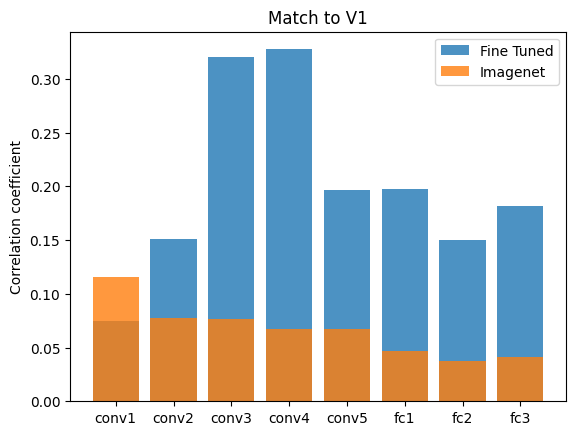

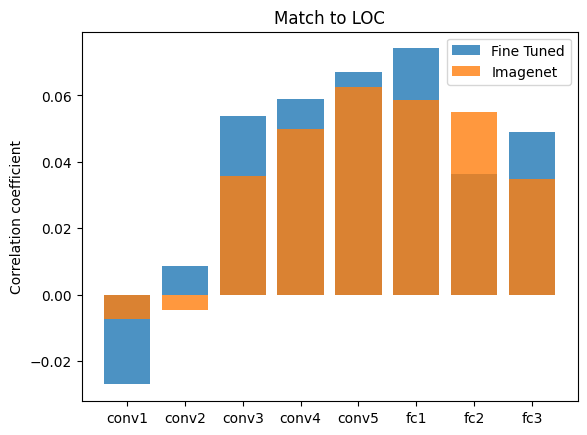

In [199]:
# @title Plotting correlation between observed and predicted dissimilarity values
############## TO DO ###############
plt.figure()
plt.bar(range(8), corr_plot[0, :], alpha=0.8)
plt.bar(range(8), corr_plot[1, :], alpha=0.8)
plt.xticks(range(8), mid_outputs_ft.keys())
plt.ylabel('Correlation coefficient')
plt.title('Match to V1')
plt.legend(['Fine Tuned', 'Imagenet'])
plt.show()
plt.figure()
plt.bar(range(8), corr_plot[2, :], alpha=0.8)
plt.bar(range(8), corr_plot[3, :], alpha=0.8)
plt.xticks(range(8), mid_outputs_ft.keys())
plt.ylabel('Correlation coefficient')
plt.title('Match to LOC')
plt.legend(['Fine Tuned', 'Imagenet'])
plt.show()

**Describle Results in details :**

The provided results consist of two bar plots comparing the correlation coefficients between observed and predicted dissimilarity values for different layers of AlexNet. The comparisons are made between a fine-tuned AlexNet model and an ImageNet-pretrained AlexNet model, focusing on two specific brain regions: V1 (primary visual cortex) and LOC (lateral occipital complex). The results demonstrate that fine-tuning a pre-trained AlexNet model improves its alignment with V1 responses, particularly in the middle convolutional layers. However, for LOC, the pre-trained model shows better performance in the later layers, suggesting that the features learned from the large-scale ImageNet dataset are well-suited for higher-level visual tasks.

 - plot 1 :     
    - The fine-tuned model significantly improves the correlation with V1 responses, especially in the middle convolutional layers (conv3 and conv4). This suggests that fine-tuning helps the model better capture the characteristics of V1, which processes basic visual features like edges and orientations.
    - The fine-tuned model generally shows higher correlation coefficients across most layers compared to the ImageNet-pretrained model. 
    - The highest correlations are observed in the conv3 and conv4 layers for the fine-tuned model.
    - The conv1 layer has relatively low correlation for both models, indicating that the initial layers capture more generic features not highly specific to V1 responses.
 - Plot 2 :
    - The fine-tuned model shows modest improvements in the early convolutional layers but does not match the performance of the ImageNet-pretrained model in the later layers. This indicates that while fine-tuning helps in capturing basic features, it might not fully adapt to the complex visual processing characteristics of LOC, which deals with object recognition and higher-level visual processing.
    - The ImageNet-pretrained model shows higher correlations in the later layers (conv4, conv5, fc1, fc2, fc3), particularly in the fully connected layers.
    - The fine-tuned model shows an improvement in correlation in the earlier convolutional layers (conv1, conv2, conv3), but it generally lags behind the ImageNet-pretrained model in the later layers.
    - The conv1 layer shows a negative correlation for the fine-tuned model, indicating poor matching to LOC responses at this initial stage.